In [ ]:
import sys, numpy as np, matplotlib.pyplot as plt, networkx as nx, scipy
sys.path.insert(0, '../')
from PlexSim.Models.FastIsing import Ising
from Utils import IO

g = nx.Graph()
g.add_edge(0, 1, weight = 1); g.add_edge(1, 2, weight = 1); g.add_edge(2, 0, weight = 3)
# g = nx.barabasi_albert_graph(100, 2)
dataDir = '../Psycho' # relative path careful
df    = IO.readCSV(f'{dataDir}/Graph_min1_1.csv', header = 0, index_col = 0)
h     = IO.readCSV(f'{dataDir}/External_min1_1.csv', header = 0, index_col = 0)
g   = nx.from_pandas_adjacency(df)
#attr = {}
#for node, row in h.iterrows():
#    attr[node] = dict(H = row['externalField'], nudges = 0)
#nx.set_node_attributes(g, attr)i
print(g.edges())
edge = np.random.choice(range(len(g.edges())))
# a, b = list(g.edges())[edge]
# WEIGHT = -np.inf
# nx.set_edge_attributes(g, {(i,j): dict(weight = 1) if not (i,j) == (a, b) else dict(weight = WEIGHT) for i, j in g.edges()})
print(list(g.edges())[edge])


m = Ising(graph = g, updateType = 'single')
temps = np.linspace(0, 5)
mag, sus = np.asarray([m.matchMagnetization(temps, n = 100) for i in range(1)]).mean(0)
from scipy import ndimage
mag = ndimage.gaussian_filter1d(mag, 1)
idx = np.argmin(abs(mag - .8 * mag.max()))
# idx = np.argmax(sus)
m.t = temps[idx]



/home/casper/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/home/casper/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


0.5102040816326531 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


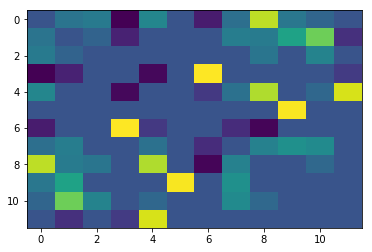

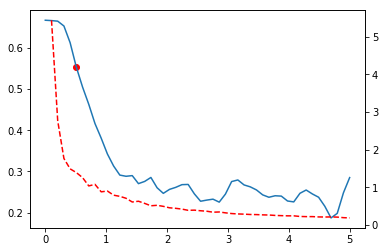

In [2]:
# show adj
fig, ax = plt.subplots()
ax.imshow(nx.adj_matrix(m.graph).todense(), aspect = 'auto')
fig.show()
# plot mags  
fig, ax = plt.subplots()
ax.plot(temps, mag)
tax = ax.twinx()
tax.plot(temps, sus, color = 'red', linestyle = 'dashed')
ax.scatter(temps[idx], mag[idx], color = 'red')
fig.show()
print(m.t, m.H.base)

In [3]:
from Toolbox import infcy
from Utils.stats import KL
nSamples = 1000
steps    = 1000
deltas   = 100
NUDGE = .1
repeats = int(1e4)
snapshots    = infcy.getSnapShots(m, nSamples = nSamples, steps = steps,  nThreads = -1)
conditional, px, mi = infcy.runMC(m, snapshots, deltas, repeats)

out = np.zeros((m.nNodes, deltas))
for node, idx in m.mapping.items():
    m.nudges = {node : NUDGE}
    c, p, n = infcy.runMC(m, snapshots, deltas, repeats)
    out[idx, :] = KL(px, p).sum(-1)

  0%|          | 0/164 [00:00<?, ?it/s]

done
Found 164 states
Delta =  0.58 sec
Decoding..
starting runs


100%|██████████| 164/164 [00:22<00:00,  4.83it/s]
/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log2
  if __name__ == '__main__':
/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


Delta =  22.63 sec


KeyError: (-1, -1, -1, -1, 1, 1, -1, 1, -1, 1, -1, 1)

In [ ]:
from matplotlib import style; style.use('seaborn-poster')

colors = plt.cm.tab20(np.arange(0, m.nNodes))
causal_auc =  np.trapz(out[:, deltas // 2 : ], axis = 1)
mi_auc     = np.trapz(mi[:deltas // 2, :], axis = 0)
fig, ax = plt.subplots()
for node, idx in m.mapping.items():
    ax.scatter(mi_auc[idx], causal_auc[idx], label = node, color = colors[idx])
ax.legend()
ax.set(xlabel = 'MI auc', ylabel = 'Causal impact auc')
fig.show()

fig, (ax1, ax2) = plt.subplots(1, 2)
for node, idx in m.mapping.items():
    ax1.plot(mi[:, idx], label = node, color = colors[idx])
    ax2.plot(out[idx], label = node, color = colors[idx])
ax2.legend(bbox_to_anchor = (1.05, 1))
# ax2.set_xlim(deltas // 2, deltas // 2 + 3)
# ax1.set_xlim(0, 3)
ax1.set_title('MI'); ax2.set_title('Causal impact)')
print(out.shape, mi.shape)

print(m.nudges.base)